# Gender classification
Author: Michelle Foo \
Code based on Tensorflow Hub transfer learning tutorial. \
Models: InceptionV3, Mobilenet \
Dataset: FEI, KinFace \

Description: Retrain the last layer of the models for gender classification.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [0]:
DATASET = "genki4k" # KinFace_V2, FEI_Frontal, genki4k, colorferet

data_root = "/content/drive/My Drive/dataset/" + DATASET
train_data = data_root + "/train"
test_data = data_root + "/test"

# model_name = "INCEPTIONV3"
# SIZE = 299

model_name = "MOBILENET"
SIZE = 224

save_model = "/content/drive/My Drive/dataset/model/" + DATASET + "_" + model_name + ".h5" 

IMAGE_SHAPE = (SIZE, SIZE)

In [0]:
# train input data augmentation, validation input 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, rotation_range=25, width_shift_range=0.1,
                                     height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                                     horizontal_flip=True, fill_mode="nearest", validation_split=0.3)
train_images = image_generator.flow_from_directory(str(train_data), target_size=IMAGE_SHAPE, subset='training', shuffle=True)
val_images = image_generator.flow_from_directory(str(train_data), target_size=IMAGE_SHAPE, subset='validation', shuffle=True)

# test data input
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_images = test_image_generator.flow_from_directory(str(test_data), target_size=IMAGE_SHAPE, batch_size=801)

Found 2240 images belonging to 2 classes.
Found 959 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


In [0]:
for train_image_batch, train_label_batch in train_images:
  print("Image batch shape: ", train_image_batch.shape)
  print("Label batch shape: ", train_label_batch.shape)
  break

for val_image_batch, val_label_batch in val_images:
  print("Image batch shape: ", val_image_batch.shape)
  print("Label batch shape: ", val_label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [0]:
for test_image_batch, test_label_batch in test_images:
  print("Image batch shape: ", test_image_batch.shape)
  print("Label batch shape: ", test_label_batch.shape)
  break

Image batch shape:  (801, 224, 224, 3)
Label batch shape:  (801, 2)


In [0]:
if model_name  == "INCEPTIONV3":
  feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"
  feature_extractor_layer = hub.KerasLayer(feature_extractor_url, 
                                          output_shape=[1001])
  feature_extractor_layer.build([None, SIZE, SIZE, 3])  # Batch input shape.

elif model_name  == "MOBILENET":
  feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
  feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                          input_shape=(SIZE,SIZE,3))
  feature_batch = feature_extractor_layer(train_image_batch)


feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_images.num_classes, activation='softmax')
])

model.build([None, SIZE, SIZE, 3])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
batch_stats_callback = CollectBatchStats()
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=save_model, verbose=1, save_best_only=True, save_weights_only=True, save_freq="epoch")
  
history = model.fit_generator(train_images, 
                              steps_per_epoch = np.ceil(train_images.samples/train_images.batch_size),
                              validation_data = val_images, 
                              validation_steps = val_images.samples // val_images.batch_size,
                              epochs=10,
                              callbacks = [batch_stats_callback, checkpointer])

print('Model accuracy on test set: ', model.evaluate(test_images)[1])

Epoch 1/10
29/70 [===========>..................] - ETA: 7:28 - loss: 0.5929 - acc: 0.6907
Epoch 00001: val_loss improved from inf to 0.59293, saving model to /content/drive/My Drive/dataset/model/genki4k_MOBILENET.h5
70/70 [==============================] - 1048s 15s/step - loss: 0.6497 - acc: 0.8438 - val_loss: 0.5929 - val_acc: 0.6907
Epoch 2/10
29/70 [===========>..................] - ETA: 19s - loss: 0.5353 - acc: 0.7317
Epoch 00002: val_loss improved from 0.59293 to 0.53529, saving model to /content/drive/My Drive/dataset/model/genki4k_MOBILENET.h5
70/70 [==============================] - 37s 528ms/step - loss: 0.5508 - acc: 0.7188 - val_loss: 0.5353 - val_acc: 0.7317
Epoch 3/10
29/70 [===========>..................] - ETA: 19s - loss: 0.5240 - acc: 0.7381
Epoch 00003: val_loss improved from 0.53529 to 0.52404, saving model to /content/drive/My Drive/dataset/model/genki4k_MOBILENET.h5
70/70 [==============================] - 37s 523ms/step - loss: 0.5077 - acc: 0.7500 - val_loss:

In [0]:
# evaluate best saved model on test data
model.load_weights(save_model)
print('Model accuracy on test set: ', model.evaluate(test_images))

1/1 [==============================] - 2s 2s/step - loss: 0.6978 - acc: 0.6305
Model accuracy on test set:  [0.6977704167366028, 0.63046193]


In [0]:
# plot training loss curve
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

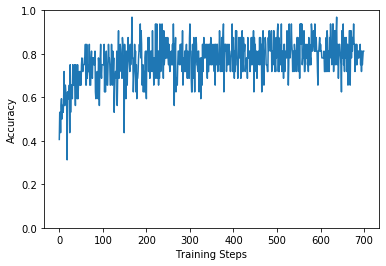

In [0]:
# plot training accuracy curve
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

In [0]:
# get class names
class_names = sorted(test_images.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Female', 'Male'], dtype='<U6')

In [0]:
# get predictions 
predicted_batch = model.predict(test_image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(test_label_batch, axis=-1)

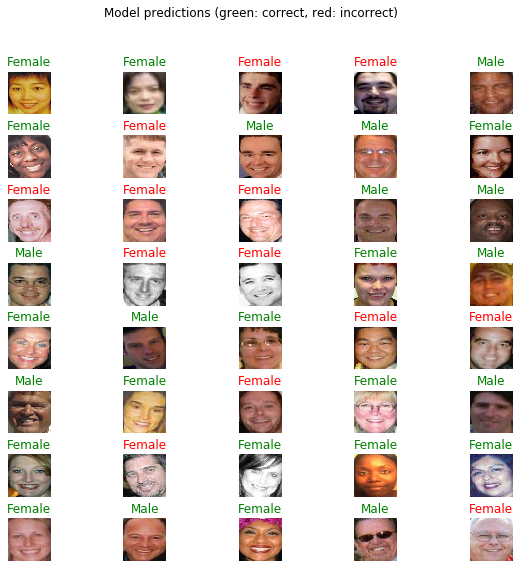

In [0]:
# show predictions
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(40):
  plt.subplot(8,5,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [0]:
# show accuracy of the classes
correct_m = 0
correct_fm = 0
for n in range(len(predicted_id)):
  if predicted_id[n] == label_id[n] and label_id[n]==1:
    correct_m = correct_m + 1
  elif predicted_id[n] == label_id[n] and label_id[n]==0:
    correct_fm = correct_fm + 1

print("Male: " + str(correct_m) + "/" + str(len(np.where(label_id==1)[0])) + " " + str(correct_m/len(np.where(label_id==1)[0])))
print("Female: " + str(correct_fm) + "/" + str(len(np.where(label_id==0)[0])) + " " + str(correct_fm/len(np.where(label_id==0)[0])))

Male: 159/409 0.38875305623471884
Female: 346/392 0.8826530612244898
